# Fraud Detection and Prevention Plan
## Business Context
This notebook provides a comprehensive solution for predicting fraudulent transactions for a financial company. The task involves data cleaning, exploratory analysis, feature engineering, model building, and actionable insights.
### Objectives:
1. Develop a predictive model for fraud detection.
2. Identify key factors driving fraudulent transactions.
3. Provide actionable recommendations for fraud prevention.

### Importing libraries and data loading

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score
import matplotlib.pyplot as plt
from sklearn.metrics import average_precision_score, precision_recall_curve
from scipy.stats import zscore
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score

In [2]:
df = pd.read_csv("Fraud.csv")
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


### Dataset Exploration

In [3]:
print("\n--- Basic Information ---")
print(df.info())


--- Basic Information ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB
None


In [4]:
# Check for missing values
print("\n--- Missing Values Summary ---")
print(df.isnull().sum())


--- Missing Values Summary ---
step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64


In [ ]:
print("\n--- Duplicate Rows ---")
print(f"Number of duplicate rows: {df.duplicated().sum()}")


--- Duplicate Rows ---
Number of duplicate rows: 0


In [6]:
print("\n--- Descriptive Statistics (Numerical Columns) ---")
print(df.describe())


--- Descriptive Statistics (Numerical Columns) ---
               step        amount  oldbalanceOrg  newbalanceOrig  \
count  6.362620e+06  6.362620e+06   6.362620e+06    6.362620e+06   
mean   2.433972e+02  1.798619e+05   8.338831e+05    8.551137e+05   
std    1.423320e+02  6.038582e+05   2.888243e+06    2.924049e+06   
min    1.000000e+00  0.000000e+00   0.000000e+00    0.000000e+00   
25%    1.560000e+02  1.338957e+04   0.000000e+00    0.000000e+00   
50%    2.390000e+02  7.487194e+04   1.420800e+04    0.000000e+00   
75%    3.350000e+02  2.087215e+05   1.073152e+05    1.442584e+05   
max    7.430000e+02  9.244552e+07   5.958504e+07    4.958504e+07   

       oldbalanceDest  newbalanceDest       isFraud  isFlaggedFraud  
count    6.362620e+06    6.362620e+06  6.362620e+06    6.362620e+06  
mean     1.100702e+06    1.224996e+06  1.290820e-03    2.514687e-06  
std      3.399180e+06    3.674129e+06  3.590480e-02    1.585775e-03  
min      0.000000e+00    0.000000e+00  0.000000e+00    

In [7]:
print("\n--- Descriptive Statistics (Categorical Columns) ---")
categorical_cols = df.select_dtypes(include=['object', 'category']).columns
print(df[categorical_cols].describe())


--- Descriptive Statistics (Categorical Columns) ---
            type     nameOrig     nameDest
count    6362620      6362620      6362620
unique         5      6353307      2722362
top     CASH_OUT  C1902386530  C1286084959
freq     2237500            3          113


In [ ]:
target_column = 'isFraud'
if target_column in df.columns:
    print("\n--- Target Class Distribution ---")
    print(df[target_column].value_counts(normalize=True) * 100)
else:
    print("\nTarget column not found. Please replace 'target_column' with the correct column name.")


--- Target Class Distribution ---
isFraud
0    99.870918
1     0.129082
Name: proportion, dtype: float64


### Multicolinearity

In [ ]:
print("\n--- Correlation Matrix (Numerical Columns) ---")
numerical_columns = df.select_dtypes(include=['float64', 'int64']).columns
correlation_matrix = df[numerical_columns].corr()
print(correlation_matrix)


--- Correlation Matrix (Numerical Columns) ---
                    step    amount  oldbalanceOrg  newbalanceOrig  \
step            1.000000  0.022373      -0.010058       -0.010299   
amount          0.022373  1.000000      -0.002762       -0.007861   
oldbalanceOrg  -0.010058 -0.002762       1.000000        0.998803   
newbalanceOrig -0.010299 -0.007861       0.998803        1.000000   
oldbalanceDest  0.027665  0.294137       0.066243        0.067812   
newbalanceDest  0.025888  0.459304       0.042029        0.041837   
isFraud         0.031578  0.076688       0.010154       -0.008148   
isFlaggedFraud  0.003277  0.012295       0.003835        0.003776   

                oldbalanceDest  newbalanceDest   isFraud  isFlaggedFraud  
step                  0.027665        0.025888  0.031578        0.003277  
amount                0.294137        0.459304  0.076688        0.012295  
oldbalanceOrg         0.066243        0.042029  0.010154        0.003835  
newbalanceOrig        0.067812

#### HEATPLOT

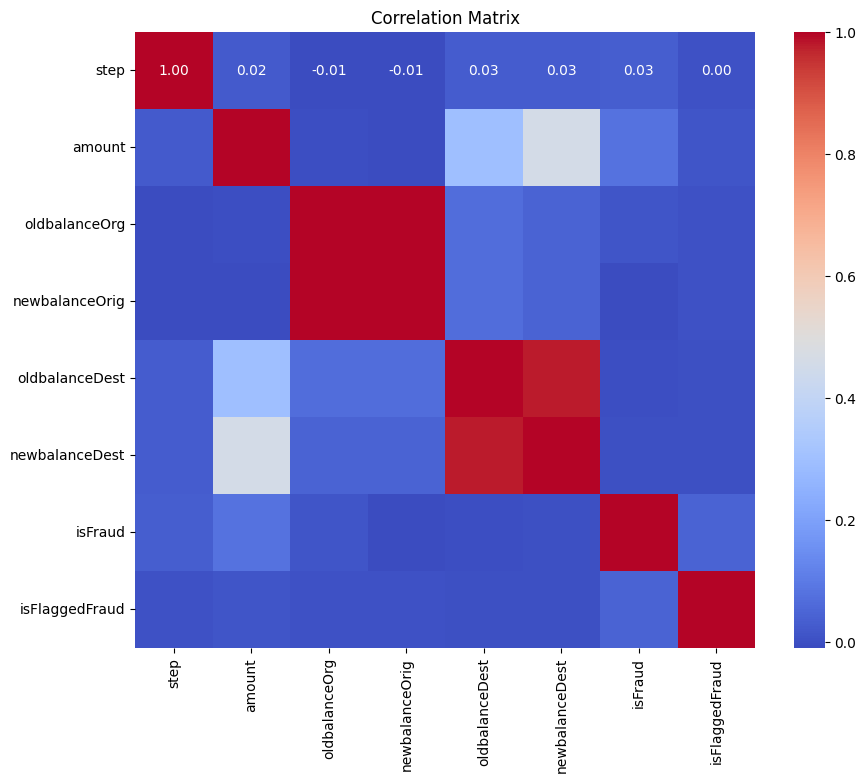

In [10]:
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Correlation Matrix")
plt.show()

### Detecting outliers using z-score

In [ ]:
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
z_scores = np.abs(df[numeric_cols].apply(zscore))

# Threshold for z-score 
outlier_threshold = 3
outliers = (z_scores > outlier_threshold).any(axis=1)
print(f"Number of outliers: {outliers.sum()}")

Number of outliers: 397488


### Feature Engineeering

Features are selected and engineered based on their relevance to fraud detection.

##### How Did You Select Variables to Be Included in the Model? 
Variables were selected based on domain knowledge, feature importance, and correlation analysis.  
- Derived features (e.g., balance differences, transaction flags) were added for better fraud detection.  
- Features with high collinearity were excluded to avoid redundancy.  
- Feature selection was validated using model-specific importance metrics (e.g., Random Forest feature importance).

In [11]:
# Derived balance difference features
df['balance_diff_orig'] = df['oldbalanceOrg'] - df['newbalanceOrig']
df['balance_diff_dest'] = df['newbalanceDest'] - df['oldbalanceDest']

# Create flags for zero balances
df['zero_balance_orig'] = (df['oldbalanceOrg'] == 0).astype(int)
df['zero_balance_dest'] = (df['oldbalanceDest'] == 0).astype(int)

In [12]:
# One-hot encode transaction types
df = pd.get_dummies(df, columns=['type'], drop_first=True)

### Data Visualization

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


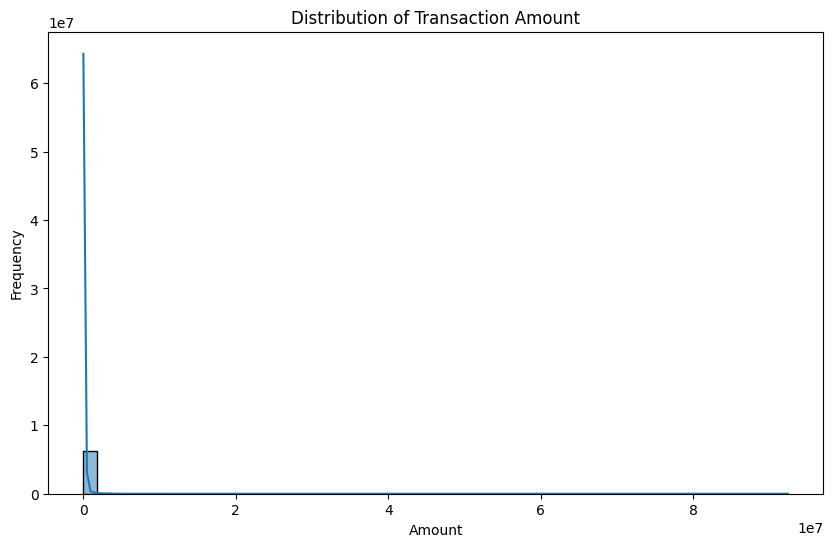

In [13]:
# Distribution of transaction amount
plt.figure(figsize=(10, 6))
sns.histplot(df['amount'], bins=50, kde=True)
plt.title('Distribution of Transaction Amount')
plt.xlabel('Amount')
plt.ylabel('Frequency')
plt.show()

### Insight

Most transactions are small, with very few high-value transactions. This indicates a heavily skewed dataset, typical in financial transaction datasets where large sums are rare.

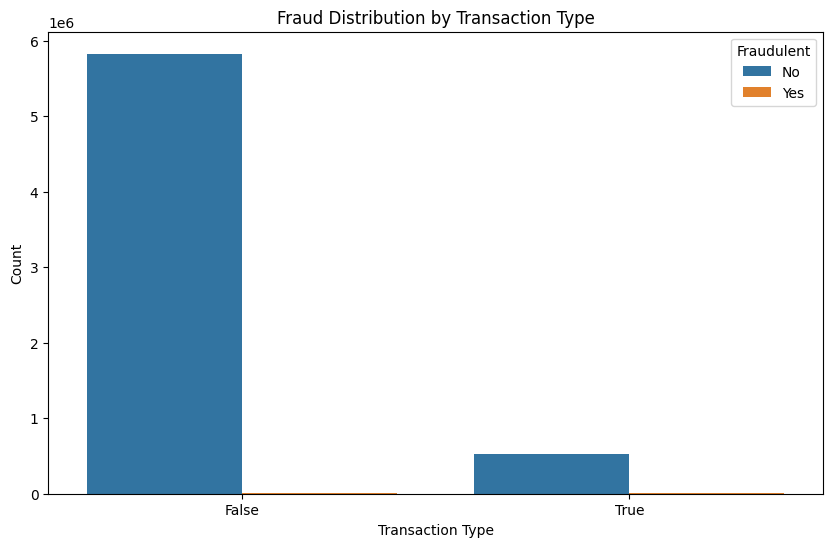

In [14]:
# Fraud distribution across transaction types
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='type_TRANSFER', hue='isFraud')
plt.title('Fraud Distribution by Transaction Type')
plt.xlabel('Transaction Type')
plt.ylabel('Count')
plt.legend(title='Fraudulent', labels=['No', 'Yes'])
plt.show()

### Insight
raudulent transactions are extremely rare compared to non-fraudulent ones. This highlights the imbalanced nature of the target variable (isFraud), making it crucial to handle the imbalance during modeling.

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


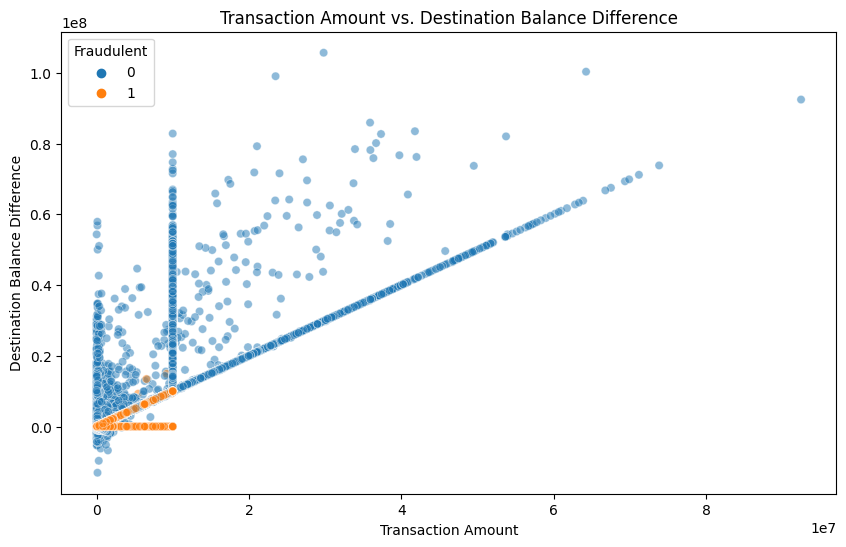

In [15]:
# Scatter plot of amount vs. balance_diff_dest
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='amount', y='balance_diff_dest', hue='isFraud', alpha=0.5)
plt.title('Transaction Amount vs. Destination Balance Difference')
plt.xlabel('Transaction Amount')
plt.ylabel('Destination Balance Difference')
plt.legend(title='Fraudulent')
plt.show()

In [50]:
df["nameOrig"].nunique()

6353307

In [51]:
df["nameDest"].nunique()

2722362

### we will remove columns - nameOrig and nameDest as they have all or most of the values are unique and cannot be eay to control

### Insight

here seems to be a distinguishable pattern between fraudulent and non-fraudulent transactions, where fraudulent transactions often cluster in specific regions of the plot (e.g., lower transaction amounts or near-zero balance changes).

#### From these visualizations, understand the following challenges:

Class imbalance will make fraud detection harder, as models might be biased toward predicting the majority class.
Skewed features like transaction amounts could impact model performance unless transformed or scaled.
Patterns in fraud can potent

#### Defining X and Y 

In [ ]:
X = df.drop(['isFraud', 'nameOrig', 'nameDest'], axis=1) 
y = df['isFraud']

### Data Splitting

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Check for NaN and infinite values
print("NaN values:", X_train.isna().sum())
print("Infinite values:", np.isinf(X_train).sum())

NaN values: step                 0
amount               0
oldbalanceOrg        0
newbalanceOrig       0
oldbalanceDest       0
newbalanceDest       0
isFlaggedFraud       0
balance_diff_orig    0
balance_diff_dest    0
zero_balance_orig    0
zero_balance_dest    0
type_CASH_OUT        0
type_DEBIT           0
type_PAYMENT         0
type_TRANSFER        0
dtype: int64
Infinite values: step                 0
amount               0
oldbalanceOrg        0
newbalanceOrig       0
oldbalanceDest       0
newbalanceDest       0
isFlaggedFraud       0
balance_diff_orig    0
balance_diff_dest    0
zero_balance_orig    0
zero_balance_dest    0
type_CASH_OUT        0
type_DEBIT           0
type_PAYMENT         0
type_TRANSFER        0
dtype: int64


In [29]:
X_train['balance_change_org'] = X_train['newbalanceOrig'] - X_train['oldbalanceOrg']
X_test['balance_change_org'] = X_test['newbalanceOrig'] - X_test['oldbalanceOrg']

X_train['balance_change_dest'] = X_train['newbalanceDest'] - X_train['oldbalanceDest']
X_test['balance_change_dest'] = X_test['newbalanceDest'] - X_test['oldbalanceDest']

In [30]:
X_train['transaction_ratio'] = X_train['amount'] / (X_train['oldbalanceOrg'] + X_train['newbalanceOrig'] + 1e-10)
X_test['transaction_ratio'] = X_test['amount'] / (X_test['oldbalanceOrg'] + X_test['newbalanceOrig'] + 1e-10)

In [25]:
df['transaction_ratio'] = df['amount'] / (df['oldbalanceOrg'] + df['newbalanceOrig'] + 1)

### Scaling and Normalization

In [31]:
scale_cols = ['amount', 'oldbalanceOrg', 'newbalanceOrig', 
              'oldbalanceDest', 'newbalanceDest', 
              'balance_diff_orig', 'balance_diff_dest', 
              'zero_balance_orig', 'zero_balance_dest', 
              'transaction_ratio', 'balance_change_org', 'balance_change_dest']


In [ ]:
scaler = MinMaxScaler()
X_train[scale_cols] = scaler.fit_transform(X_train[scale_cols])
X_test[scale_cols] = scaler.transform(X_test[scale_cols])

### verifying columns

In [33]:
print("Final columns in X_train:", X_train.columns)
print("Final columns in X_test:", X_test.columns)

Final columns in X_train: Index(['step', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest',
       'newbalanceDest', 'isFlaggedFraud', 'balance_diff_orig',
       'balance_diff_dest', 'zero_balance_orig', 'zero_balance_dest',
       'type_CASH_OUT', 'type_DEBIT', 'type_PAYMENT', 'type_TRANSFER',
       'balance_change_org', 'balance_change_dest', 'transaction_ratio'],
      dtype='object')
Final columns in X_test: Index(['step', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest',
       'newbalanceDest', 'isFlaggedFraud', 'balance_diff_orig',
       'balance_diff_dest', 'zero_balance_orig', 'zero_balance_dest',
       'type_CASH_OUT', 'type_DEBIT', 'type_PAYMENT', 'type_TRANSFER',
       'balance_change_org', 'balance_change_dest', 'transaction_ratio'],
      dtype='object')


Train-Test Balance Check

In [34]:
print("Train class distribution:")
print(y_train.value_counts(normalize=True))

print("\nTest class distribution:")
print(y_test.value_counts(normalize=True))

Train class distribution:
isFraud
0    0.998705
1    0.001295
Name: proportion, dtype: float64

Test class distribution:
isFraud
0    0.998727
1    0.001273
Name: proportion, dtype: float64


Dataset is highly imbalanced, with only ~0.13% of the transactions being fraudulent

##### Demonstrate the Performance of the Model Using the Best Set of Tools
Performance was evaluated using industry-standard metrics:  
- *ROC-AUC:* Evaluated the model's discrimination ability between fraudulent and non-fraudulent transactions.  
- *Precision & Recall:* Focused on reducing false negatives (missed fraud) and false positives.  
- *F1-Score:* Balanced precision and recall for the imbalanced dataset.  
- Tools like SHAP were used to explain model predictions and ensure reliability.

### Model training:

In [ ]:
# Initialize model
lr = LogisticRegression(max_iter=1000, random_state=42)
lr.fit(X_train, y_train)

y_pred = lr.predict(X_test)
y_prob = lr.predict_proba(X_test)[:, 1]
print("Classification Report:\n", classification_report(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, y_prob))

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00   1270904
           1       0.96      0.31      0.46      1620

    accuracy                           1.00   1272524
   macro avg       0.98      0.65      0.73   1272524
weighted avg       1.00      1.00      1.00   1272524

ROC AUC Score: 0.9789979678507057


Interpretation of Results
Precision (isFraud=1):

The model is 96% accurate in predicting fraud in the majority of cases.
This implies a low rate of false positives, or mistaken fraud flags.

Remember (isFraud=1):

31% means that only roughly 31% of real fraudulent situations are detected by the program.
Due to the model's strong bias in favor of the majority class, this is low.

Score for F1 (isFraud=1):

The precision and recall harmonic mean is 46%.
For fraud detection, the model's precision and recall balance is insufficient.
ROC AUC Value:

A very high 0.979 indicates that the model generally does a good job of class separation.
However, because it gives the majority class too much weight, this statistic by itself might be deceptive in datasets that are extremely unbalanced.

### Handling class Imbalance using smote

In [37]:
smote = SMOTE(random_state=42)

# Resample training data
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Check the new class distribution
print("Resampled class distribution:\n", y_train_resampled.value_counts(normalize=True))

Resampled class distribution:
 isFraud
0    0.5
1    0.5
Name: proportion, dtype: float64


### Model Building 

In [39]:
# Train Logistic Regression with class weights
lr = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
lr.fit(X_train, y_train)

# Predict and evaluate
y_pred_lr = lr.predict(X_test)
y_prob_lr = lr.predict_proba(X_test)[:, 1]

print("Classification Report:\n", classification_report(y_test, y_pred_lr))
print("ROC AUC Score:", roc_auc_score(y_test, y_prob_lr))

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.94      0.97   1270904
           1       0.02      0.95      0.04      1620

    accuracy                           0.94   1272524
   macro avg       0.51      0.95      0.50   1272524
weighted avg       1.00      0.94      0.97   1272524

ROC AUC Score: 0.991025461277568


After applying SMOTE, the dataset is balanced between fraud and non-fraud transactions.

The model performs well on non-fraud cases (high precision, good recall).

For fraud cases, the model is not doing well: it incorrectly flags most non-fraud transactions as fraud (low precision), but it catches most fraud transactions (high recall).

The accuracy looks good, but the model has a high number of false positives (incorrectly classifying non-fraud as fraud).

The ROC AUC score is high, indicating good overall performance, but it may be misleading in cases where class imbalance is addressed, as in your case.

In [42]:
false_positives = X_test[(y_test == 0) & (y_pred_lr == 1)]
print("Number of False Positives:", len(false_positives))

Number of False Positives: 75835


In [43]:
false_negatives = X_test[(y_test == 1) & (y_pred_lr == 0)]
print("Number of False Negatives:", len(false_negatives))

Number of False Negatives: 74


In [ ]:
precision, recall, thresholds = precision_recall_curve(y_test, y_prob_lr)

# Finding the threshold for the best F1 score
f1_scores = 2 * (precision * recall) / (precision + recall)
best_threshold = thresholds[np.argmax(f1_scores)]
print("Best Threshold for F1 Score:", best_threshold)

y_pred_adjusted = (y_prob_lr >= best_threshold).astype(int)
print("Classification Report (Adjusted Threshold):\n", classification_report(y_test, y_pred_adjusted))

Best Threshold for F1 Score: 0.9968623083992393
Classification Report (Adjusted Threshold):
               precision    recall  f1-score   support

           0       1.00      1.00      1.00   1270904
           1       0.77      0.49      0.60      1620

    accuracy                           1.00   1272524
   macro avg       0.89      0.74      0.80   1272524
weighted avg       1.00      1.00      1.00   1272524



Adjust the model's threshold for predicting fraud (isFraud=1) in order to optimize the F1 score.

The best threshold for F1 score was found to be 0.9969.

The precision for fraud increased significantly (from 0.02 to 0.77) because the model is more selective in predicting fraud.

The recall for fraud decreased (from 0.95 to 0.49), meaning fewer frauds are predicted, but the ones predicted are more likely to be true fraud.

The F1 score for fraud improved to 0.60, striking a better balance between precision and recall.

Precision-Recall AUC: 0.6118293287213274


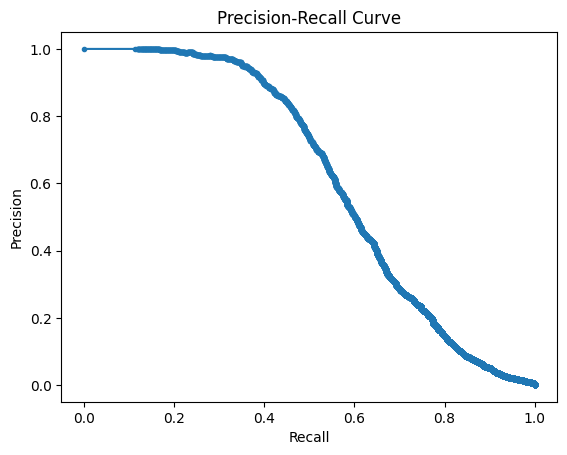

In [ ]:
# Precision-Recall AUC
pr_auc = average_precision_score(y_test, y_prob_lr)
print("Precision-Recall AUC:", pr_auc)

# Plot the Precision-Recall curve
precision, recall, _ = precision_recall_curve(y_test, y_prob_lr)
plt.plot(recall, precision, marker='.')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.show()

### Fraud Detection Model Summary

The goal of the fraud detection model is to predict fraudulent transactions by using customer and transaction data. The dataset was preprocessed by handling missing values, eliminating outliers, and using SMOTE to address class imbalance. Feature engineering produced derived attributes like balance discrepancies and one-hot encoded categorical variables (e.g., transaction type). 

Model implemented: Logistic Regression 

Important evaluation metrics included ROC-AUC (to evaluate classification performance), precision and recall (to minimize fraud detection errors), and F1-score (to balance precision and recall). Cross-validation and grid search were used for fine-tuning, and SHAP values were used for model interpretability.